# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

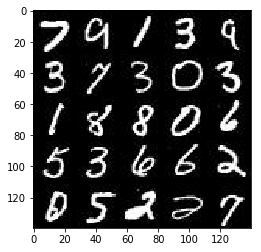

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

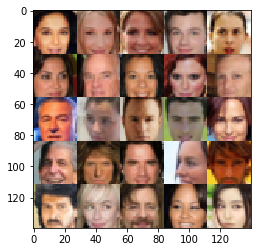

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob=0.8)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.dropout(tf.maximum(alpha * bn2, bn2), keep_prob=0.8)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.dropout(tf.maximum(alpha * bn3, bn3), keep_prob=0.8)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob=0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(tf.maximum(alpha * x2, x2), keep_prob=0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(tf.maximum(alpha * x3, x3), keep_prob=0.5)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.dropout(tf.maximum(alpha * x4, x4), keep_prob=0.5)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        
        logits = tf.image.resize_images(logits, size=[28, 28])
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
        labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
        labels=tf.ones_like(d_model_fake)*0.9))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2609... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 2.7528... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 1.6771
Epoch 1/2... Discriminator Loss: 2.4090... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.8357... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.6662... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.8028


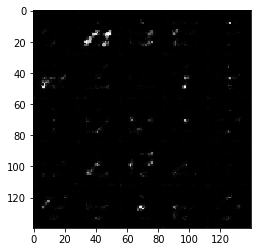

Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.5249... Generator Loss: 1.1167
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.7493


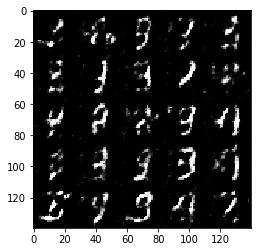

Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 1.1989
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.7767


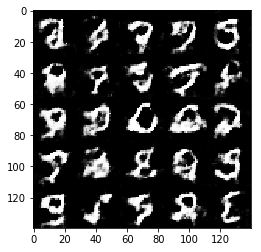

Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 1.1784
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.8384


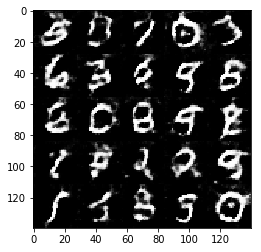

Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 1.1923
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.8564
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.9832


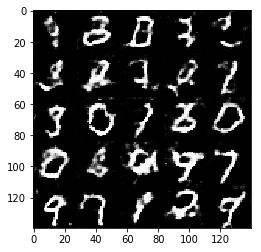

Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 1.0357
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.7825


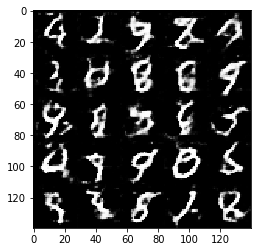

Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 1.3128
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.9187
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 1.2273


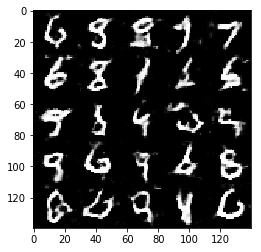

Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.1831
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 1.3075
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 1.3856


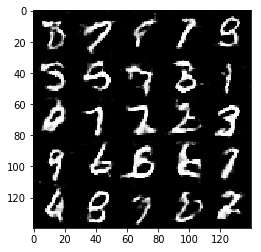

Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 1.5018
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.1267


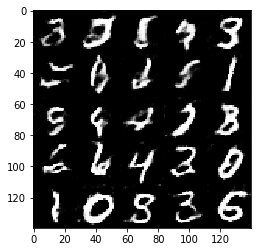

Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 1.6287
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.2134
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 1.0736


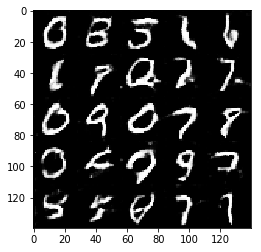

Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 1.3259


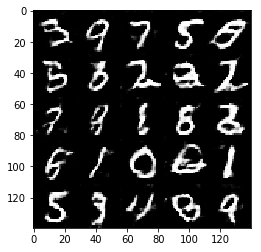

Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.2410
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 1.3289
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 1.6887
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 1.6805


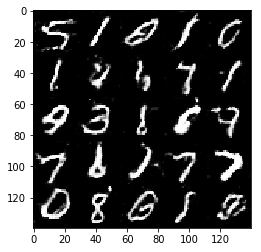

Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 1.8660... Generator Loss: 2.3044
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.9978


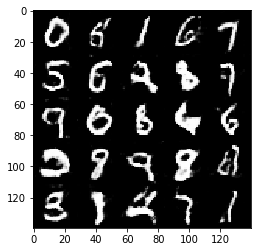

Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 0.9890
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 1.7144
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.4156
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.7003
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.5753
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.9416


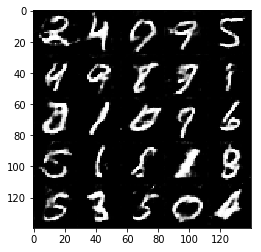

Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.5461
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.1615
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 1.7504
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.9708


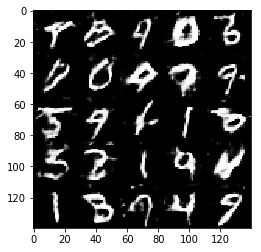

Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 1.1379
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 1.7029
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 0.8888


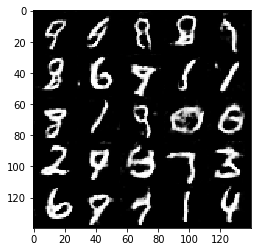

Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 1.6380
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.9172
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 1.2808


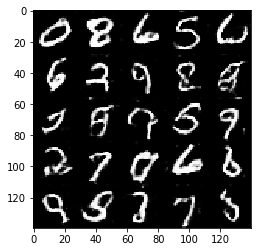

Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 1.8821
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 1.1569
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 1.0039
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.0111
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.8241


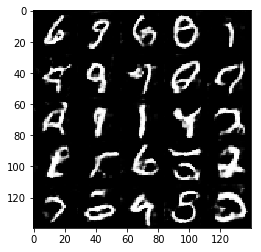

Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.5688
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 1.1817
Epoch 2/2... Discriminator Loss: 1.5402... Generator Loss: 2.9093
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 2.0258
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.0581


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .0004
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1075... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 3.2799... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 4.1554
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 2.4537
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 2.3155
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 2.8225
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.9890


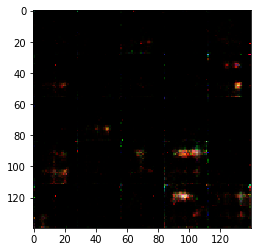

Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.6944
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.7529
Epoch 1/1... Discriminator Loss: 1.8246... Generator Loss: 0.5470


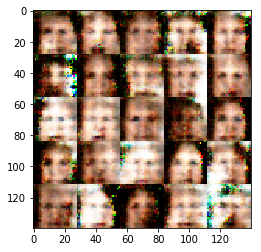

Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1193


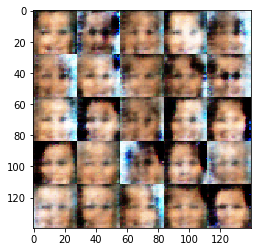

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.9023
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.5071


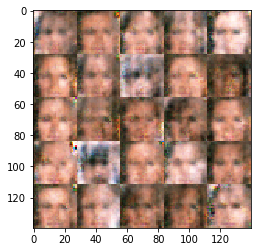

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.6589... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.0155


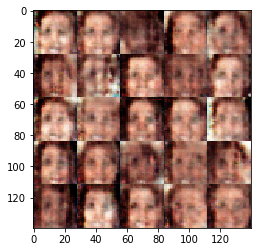

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.8443


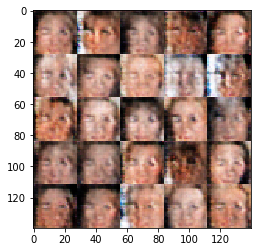

Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.4075


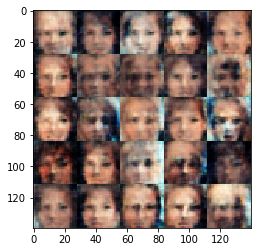

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.9094


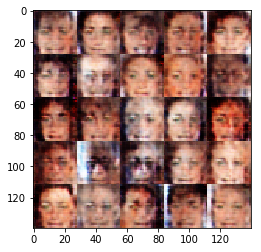

Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 1.0061


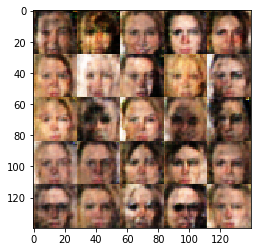

Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8773


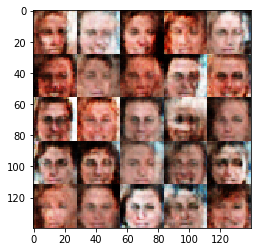

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.7406... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8703


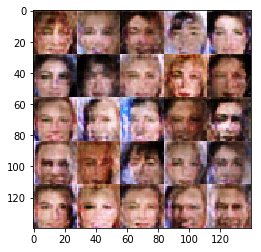

Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6898


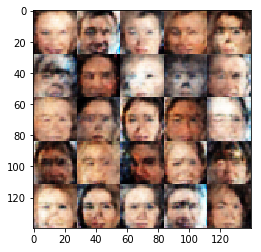

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.9293


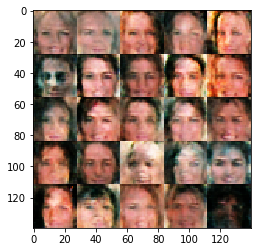

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6902


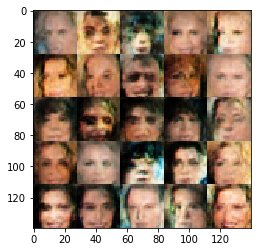

Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8291


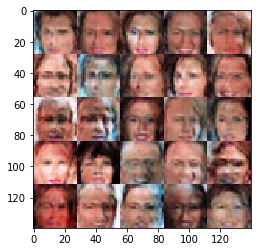

Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9007


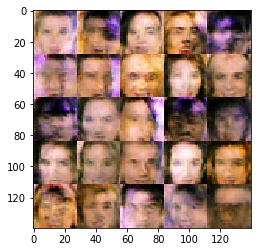

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.9270


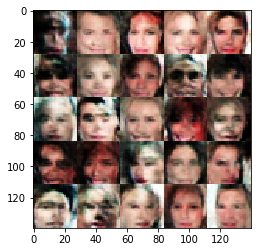

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9128


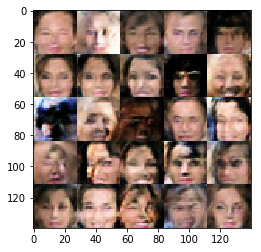

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9148


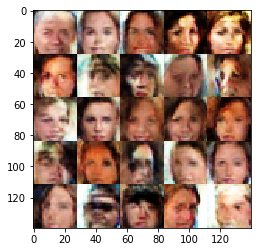

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8340


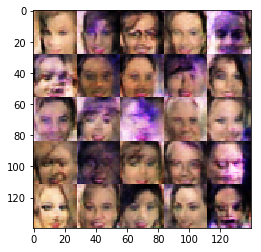

Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7078


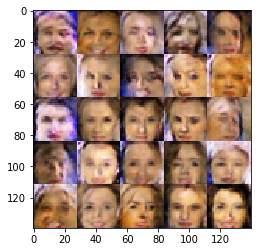

Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8129


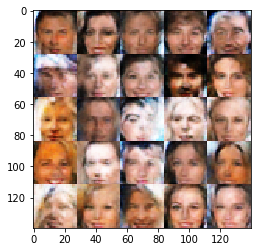

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8412


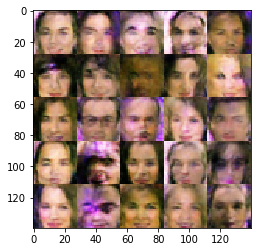

Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8210


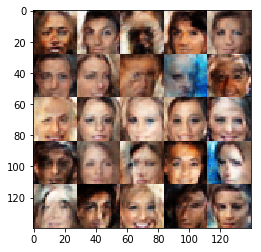

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.9857


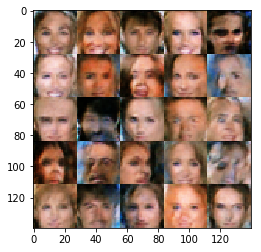

Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8183


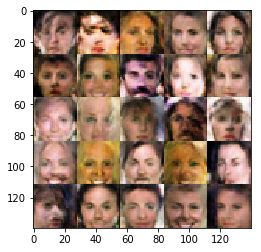

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8285


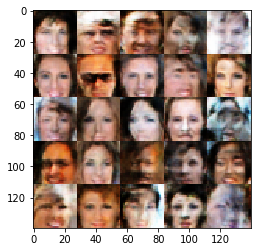

Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.8198


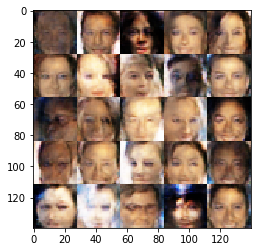

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.9749


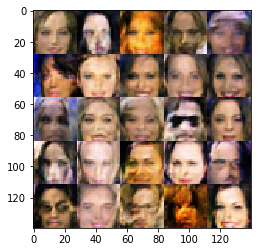

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.9012


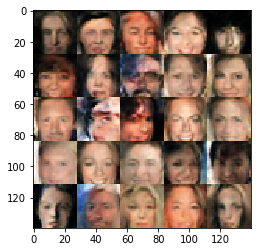

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7656


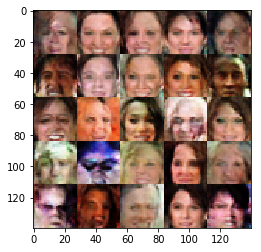

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8762


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0004
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.